A identificação e a capacidade de classificar os clientes com base nos gastos sempre foram uma área de 
interesse para instituições bancárias e empresas de cartão de crédito. É um aspecto importante no 
gerenciamento de relacionamento com o cliente e ajuda a aumentar a receita com clientes existentes. Várias 
 tentativas foram feitas a esse respeito. Os emissores de cartões de crédito tradicionalmente têm como alvo 
os consumidores usando informações sobre seus comportamentos e dados demográficos. 

 Nosso trabalho é classificar os clientes de cartão de crédito de acordo com seu comportamento de gastos. 
 A segmentação é um aspecto importante na compreensão do cliente e na execução de campanhas de marketing 
eficazes e rentáveis. Usaremos o SVM como nosso modelo.

Os dados demográficos, os detalhes sobre emprego e o estilo de vida dos clientes desempenham um papel vital na 
 maneira como eles gastam. Existem fatores ocultos, bem como semelhança com as compras. A máquina de vetores  de suporte pode ser usada para problemas de regressão e classificação. 

Usaremos SVM com Kernel Linear Multiclasse como nosso modelo proposto para classificar a variável target. 
No entanto, também avaliaremos outros Kernels, como RBF e Polinomial, para uma variedade de hiperparâmetros. 
Também levamos em consideração o viés no dados.

Fonte dos dados: https://sorry.vse.cz/~berka/ (dados anônimos)


In [1]:
#Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Carregando os dados
data = pd.read_csv("cartoes_clientes.csv")

In [3]:
data.head()

,custid,townsize,gender,age,birthmonth,ed,jobcat,union,employ,retire,...,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,Customer_cat
0,3964-QJWTRG-NPN,2.0,1,20,September,15,1,1,0,0,...,0,0,1,1,0,0,0,1,0,low_spend_cust
1,0648-AIPJSP-UVM,5.0,0,22,May,17,2,0,0,0,...,1,1,1,1,1,1,0,0,0,low_spend_cust
2,5195-TLUDJE-HVO,4.0,1,67,June,14,2,0,16,0,...,0,0,0,0,0,1,0,0,0,low_spend_cust
3,4459-VLPQUH-3OL,3.0,0,23,May,16,2,0,0,0,...,0,1,1,1,0,1,1,0,0,medium_spend_cust
4,8158-SMTQFB-CNO,2.0,0,26,July,16,2,0,1,0,...,0,1,0,1,0,0,0,1,0,medium_spend_cust


In [4]:
#Retirando a coluna "custid"
data.drop('custid', axis=1, inplace=True)

In [5]:
#Verificando a quantidade de linhas e colunas
data.shape

(5000, 117)

In [6]:
#Verificando os diferentes tipos de dados
pd.unique(data.dtypes)

array([dtype('float64'), dtype('int64'), dtype('O')], dtype=object)

In [7]:
# seleciona apenas as colunas object

dados_cat = data.select_dtypes(include='object')

In [8]:
# seleciona as colunas numéricas

dados_num = data.select_dtypes(exclude= 'object')

In [9]:
dados_cat.shape, dados_num.shape

((5000, 2), (5000, 115))

In [10]:
#Verificando os valores da coluna Birthmonth
data['birthmonth'].value_counts()

September    458
May          451
January      420
June         420
February     418
March        416
July         413
October      410
August       406
November     399
December     398
April        391
Name: birthmonth, dtype: int64

In [11]:
#Transformando a coluna em números
data['birthmonth'] = data['birthmonth'].map({'September': 9,'May': 5,'June': 6,'January': 1,'February': 2,
                                                'March': 3,'July': 7,'October':10,'August': 8,'November':11,
                                                'December': 12,'April': 4})

In [12]:
#Verificando os valores da coluna Customer_cat
data['Customer_cat'].value_counts()

medium_spend_cust    3390
low_spend_cust       1493
high_spend_cust       117
Name: Customer_cat, dtype: int64

In [13]:
#Transformando a variávl em numeros
data['Customer_cat'] = data['Customer_cat'].astype('category')
data['Customer_cat'] = data['Customer_cat'].cat.codes

In [14]:
# Verificando quais colunas possuem valor Nan
colunas_nan = data.loc[:, data.isnull().any()].columns
    

In [15]:
data_null = data[colunas_nan]

In [16]:
data_null.isnull().sum()

townsize          2
lncreddebt        1
lnothdebt         1
commutetime       2
longten           3
lntollmon      2622
lntollten      2622
lncardmon      1422
cardten           2
lncardten      1422
lnwiremon      3656
lnwireten      3656
dtype: int64

Text(0.5, 1.0, 'Valores Ausentes')

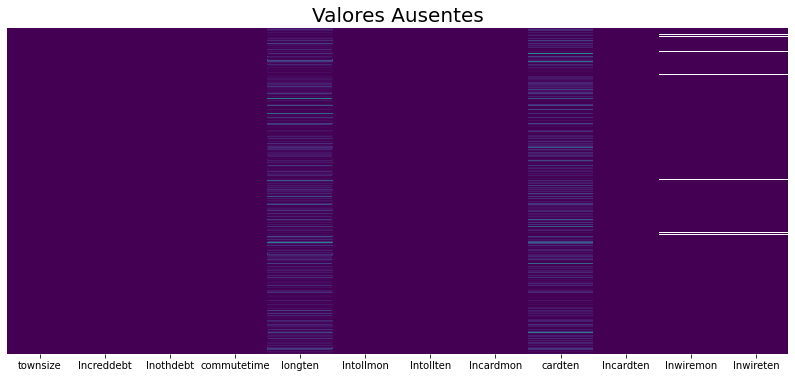

In [17]:
# Heatmap para Visualizar os Valores Ausentes por variável
plt.figure(figsize = (14,6))
p = sns.heatmap(data_null, yticklabels = False, cbar = False, cmap = 'viridis')
p.axes.set_title("Valores Ausentes", fontsize = 20)

In [18]:
# Describe mostra o resumo estatístico apenas das variáveis numéricas
data.describe()

,townsize,gender,age,birthmonth,ed,jobcat,union,employ,retire,income,...,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,Customer_cat
count,4998.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0000,5000.00000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2.687275,0.503600,47.025600,6.473800,14.543000,2.7528,0.15120,9.730400,0.147600,54.759600,...,0.201000,0.63280,0.479200,0.474800,0.178800,0.472600,0.083600,0.129800,0.102600,1.654600
std,1.425925,0.500037,17.770338,3.430986,3.281083,1.7379,0.35828,9.690929,0.354739,55.377511,...,0.400788,0.48209,0.499617,0.499415,0.383223,0.499299,0.276815,0.336117,0.303466,0.522449
min,1.000000,0.000000,18.000000,1.000000,6.000000,1.0000,0.00000,0.000000,0.000000,9.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,31.000000,3.000000,12.000000,1.0000,0.00000,2.000000,0.000000,24.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.000000,1.000000,47.000000,6.000000,14.000000,2.0000,0.00000,7.000000,0.000000,38.000000,...,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,4.000000,1.000000,62.000000,9.000000,17.000000,4.0000,0.00000,15.000000,0.000000,67.000000,...,0.000000,1.00000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
max,5.000000,1.000000,79.000000,12.000000,23.000000,6.0000,1.00000,52.000000,1.000000,1073.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [19]:
# Cria o objeto de imputação

imputer = SimpleImputer(strategy = 'median')

# Aplica a imputação
data_imput = pd.DataFrame(imputer.fit_transform(np.array(data)))

In [20]:
# Vamos retornar os nomes de colunas e os índices
data_imput.columns = data.columns
data_imput.index = data.index
data2 = data_imput

In [21]:
data2.head()

,townsize,gender,age,birthmonth,ed,jobcat,union,employ,retire,income,...,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,Customer_cat
0,2.0,1.0,20.0,9.0,15.0,1.0,1.0,0.0,0.0,31.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,5.0,0.0,22.0,5.0,17.0,2.0,0.0,0.0,0.0,15.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,4.0,1.0,67.0,6.0,14.0,2.0,0.0,16.0,0.0,35.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,3.0,0.0,23.0,5.0,16.0,2.0,0.0,0.0,0.0,20.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0
4,2.0,0.0,26.0,7.0,16.0,2.0,0.0,1.0,0.0,23.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0


In [22]:
data_imput.head()

,townsize,gender,age,birthmonth,ed,jobcat,union,employ,retire,income,...,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,Customer_cat
0,2.0,1.0,20.0,9.0,15.0,1.0,1.0,0.0,0.0,31.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,5.0,0.0,22.0,5.0,17.0,2.0,0.0,0.0,0.0,15.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,4.0,1.0,67.0,6.0,14.0,2.0,0.0,16.0,0.0,35.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,3.0,0.0,23.0,5.0,16.0,2.0,0.0,0.0,0.0,20.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0
4,2.0,0.0,26.0,7.0,16.0,2.0,0.0,1.0,0.0,23.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0


In [23]:
# Define X (variáveis explicativas) e y (variável target)
X = data_imput.drop('Customer_cat', axis = 1)
y = data_imput['Customer_cat']

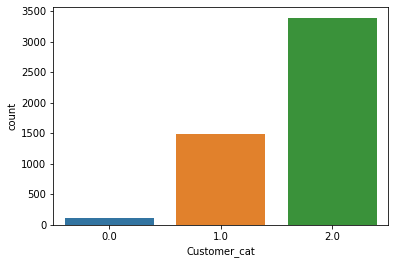

In [24]:
#Verificando o balanceamento da variável target
sns.countplot(x = y)

In [25]:
# Aplica a divisão com proporção 80/20
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.20, random_state = 101)

In [26]:
X_treino.shape,X_teste.shape,y_treino.shape,y_teste.shape

((4000, 116), (1000, 116), (4000,), (1000,))

In [27]:
# Vamos padronizar as variáveis de entrada

# Cria o padronizador
scaler = StandardScaler()

# Treina e aplica nos dados de treino
X_treino_scaled = scaler.fit_transform(X_treino.values)

# Apenas aplica nos dados de teste
X_teste_scaled = scaler.transform(X_teste.values)

In [28]:
#Balanceamento com smote
seed = 101
# Cria o balanceador SMOTE
smote_bal = SMOTE(random_state = seed)

# Aplica o balanceador
X_res, y_res = smote_bal.fit_resample(X_treino_scaled, y_treino)

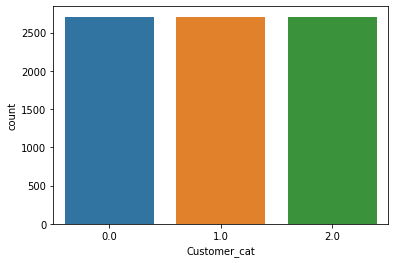

In [29]:
#Verificando o balanceamento da variável target
sns.countplot(x = y_res)

## Modelo 1 - SVM - Classificação Multiclasse - “one-versus-one”

In [30]:
# Modelo

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_res, y_res)

SVC(decision_function_shape='ovo')

In [31]:
resultado = clf.predict(X_teste_scaled)

In [32]:
# Classification Report
print(classification_report(y_teste, resultado))

              precision    recall  f1-score   support

         0.0       0.71      0.17      0.28        29
         1.0       0.71      0.69      0.70       288
         2.0       0.84      0.88      0.86       683

    accuracy                           0.80      1000
   macro avg       0.75      0.58      0.61      1000
weighted avg       0.80      0.80      0.80      1000



## Modelo 2 - SVM - Classificação Multiclasse - “one-vs-the-rest”

In [33]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X_res, y_res)

LinearSVC()

In [34]:
resultado2 = lin_clf.predict(X_teste_scaled)

In [35]:
# Classification Report
print(classification_report(y_teste, resultado2))

              precision    recall  f1-score   support

         0.0       0.32      0.86      0.47        29
         1.0       0.62      0.84      0.71       288
         2.0       0.91      0.70      0.79       683

    accuracy                           0.75      1000
   macro avg       0.61      0.80      0.66      1000
weighted avg       0.81      0.75      0.76      1000

